# Examples

(C) Henrik Boström, 2024

In [1]:
import xrf
print(f"xrf v. {xrf.__version__}")

xrf v. 0.1.0


## Classification forests

### Tic-tac-toe

Let us start by importing the tic-tac-toe dataset from [openml.org](www.openml.org).

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

dataset = fetch_openml(name="tic-tac-toe", parser="auto")

y = dataset.target.values

X_orig = dataset.data.values
X = OneHotEncoder().fit_transform(X_orig).toarray()

Let us split the dataset into a training and a test set.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, X_orig_train, X_orig_test = train_test_split(
    X, y, X_orig, test_size=0.75)

Let us first generate a standard random forest classifier and apply it to the test set.

In [4]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

np.random.seed(42)

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
rf_predictions = rf.predict_proba(X_test)

Similarly, we may generate and apply an explainable random forest classifier, here without constraining the number of training examples involved in the predictions.

In [5]:
from xrf import XRandomForestClassifier

np.random.seed(42)

rfx = XRandomForestClassifier(n_jobs=-1)
rfx.fit(X_train, y_train)
rfx_predictions = rfx.predict_proba(X_test)

Let us check that we indeed get the same predictions.

In [6]:
assert np.allclose(rf_predictions, rfx_predictions)

We may now limit the number of examples involved in a prediction, e.g., to at most 5 (`k=5`).

In [7]:
k=5

rfx_predictions_k = rfx.predict_proba(X_test, k=k)

Let us compare the predictive performance of the original and the constrained predictions.

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd

accuracy_orig = accuracy_score(y_test==rf.classes_[1], 
                               np.round(rf_predictions[:,1]))
auc_orig = roc_auc_score(y_test == rf.classes_[1], 
                         rf_predictions[:,1])

accuracy_k = accuracy_score(y_test==rfx.classes_[1], 
                              np.round(rfx_predictions_k[:,1]))
auc_k = roc_auc_score(y_test == rfx.classes_[1], 
                        rfx_predictions_k[:,1])

df_result = pd.DataFrame([[accuracy_orig, auc_orig],[accuracy_k, auc_k]], 
                  index=["Original", f"k={k}"], 
                  columns=["Accuracy", "AUC"])

display(df_result.round(3))

,Accuracy,AUC
Original,0.873,0.949
k=5,0.886,0.949


Let us take a look at the example attribution for some prediction.

In [9]:
rfx_predictions_k, examples, weights = rfx.predict_proba(
    X_test, k=k, return_examples=True, return_weights=True)

In [10]:
rf_predicted_labels = np.array([rf.classes_[p.argmax()] for p in rf_predictions])
rfx_predicted_labels = np.array([rfx.classes_[p.argmax()] for p in rfx_predictions_k])

In [11]:
def display_board(squares, Caption, Styles):
    df = pd.DataFrame(squares.reshape(3,3), 
                      columns=["","",""], 
                      index=["","",""])
    display(df.style.set_caption(Caption).set_table_styles(Styles))

In [12]:
test_index = 0 # Select some test example

props = [("color", "grey"), ("font-weight", "bold")]
Styles = [dict(selector = "caption", props = props)]
props_b = [("caption-side", "bottom")]
Styles_b = [dict(selector = "caption", props = props_b)]

df = pd.DataFrame([rf_predictions[test_index]], index = [""], 
                  columns=rf.classes_).round(2)
display(df.style.format(precision=2).set_caption("Original prediction").set_table_styles(Styles))

df = pd.DataFrame([rfx_predictions_k[test_index]], index = [""], 
                  columns=rfx.classes_).round(2)
display(df.style.format(precision=2).set_caption("Constrained prediction").set_table_styles(Styles))
    
display_board(X_orig_test[test_index],
             f"Test example [{y_test[test_index]}]",
             Styles_b)

for i, e in enumerate(examples[test_index]):
    caption = f"Example #{i+1} [{y_train[e]}, {weights[test_index][i]:.2f}]"    
    display_board(X_orig_train[examples[test_index][i]],
                 caption, Styles_b)

,negative,positive
,0.31,0.69


,negative,positive
,0.12,0.88


,,,
,o,x,x
,o,o,x
,x,o,x


,,,
,o,b,x
,o,o,x
,x,b,x


,,,
,o,o,x
,o,o,x
,x,x,x


,,,
,b,x,x
,o,o,x
,b,o,x


,,,
,o,b,b
,o,o,x
,x,x,x


,,,
,o,x,o
,o,x,x
,x,o,x


Let us check how many training examples contribute to the predictions in the original forest.

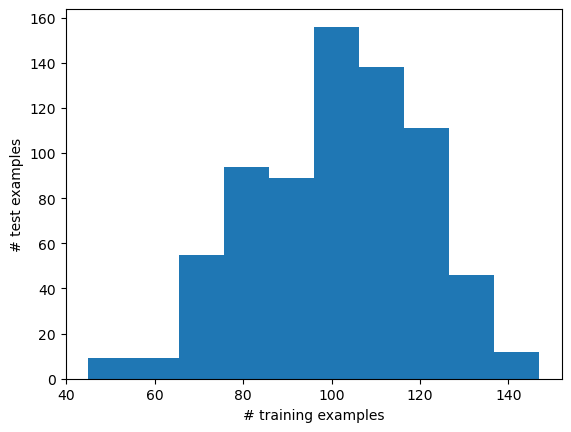

In [13]:
import matplotlib.pyplot as plt

xrfc_predictions, all_non_zero_weights = rfx.predict_proba(X_test, c=1.0, return_weights=True)

lengths = [len(w) for w in all_non_zero_weights]

plt.hist(lengths, 10)
plt.xlabel("# training examples")
plt.ylabel("# test examples")
plt.show()

assert np.allclose(rf_predictions, xrfc_predictions)

Rather than constraining the predictions to a fixed number by setting a value for `k`, we could set a limit on the cumulative sum of the highest weights, e.g., to 30% (`c=0.3`).

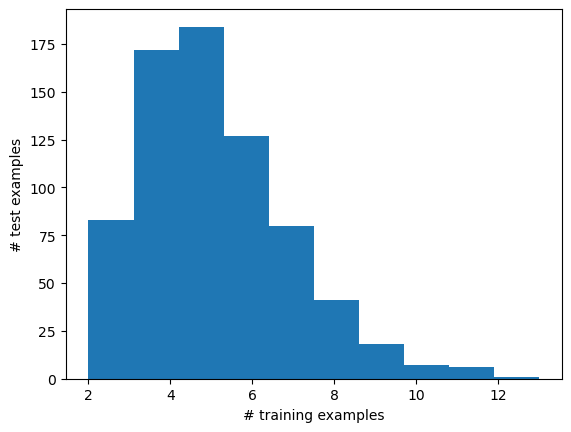

,Accuracy,AUC
Original,0.873,0.949
k=5,0.886,0.949
c=0.3,0.887,0.955


In [14]:
xrfc_predictions_c, all_non_zero_weights = rfx.predict_proba(
    X_test, c=0.3, return_weights=True)

lengths = [len(w) for w in all_non_zero_weights]

plt.hist(lengths, 10)
plt.xlabel("# training examples")
plt.ylabel("# test examples")
plt.show()

accuracy_c = accuracy_score(y_test==rfx.classes_[1], 
                            np.round(xrfc_predictions_c[:,1]))
auc_c = roc_auc_score(y_test == rfx.classes_[1], xrfc_predictions_c[:,1])

df_result.loc["c=0.3"] = [accuracy_c, auc_c]
display(df_result.round(3))

### MNIST

Let us also consider the MNIST dataset at [openml.org](www.openml.org).

In [15]:
dataset = fetch_openml(name="mnist_784", parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(int)

print(f"Original dataset size: {X.shape}")

Original dataset size: (70000, 784)


Let us split the dataset into a training and a test set.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.1)

Let us first generate a standard random forest classifier and apply it to the test set.

In [17]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

np.random.seed(42)

rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
rf.fit(X_train, y_train)
rf_predictions = rf.predict_proba(X_test)

Similarly, we may generate and apply an explainable random forest classifier, here without constraining the number of training examples involved in the predictions.

In [18]:
from xrf import XRandomForestClassifier

np.random.seed(42)

rfx = XRandomForestClassifier(n_jobs=-1, n_estimators=500)
rfx.fit(X_train, y_train)

XRandomForestClassifier(model=RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)

In [19]:
rfx_predictions, all_non_zero_weights = rfx.predict_proba(X_test, c=1.0, return_weights=True)

Let us check that we indeed get the same predictions.

In [20]:
assert np.allclose(rf_predictions, rfx_predictions)

Let us check how many training examples contribute to the predictions.

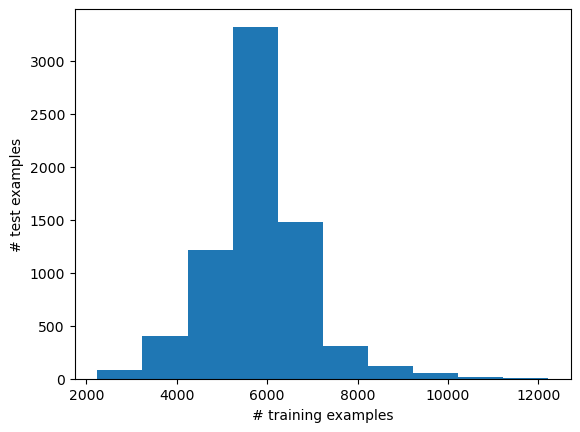

In [21]:
import matplotlib.pyplot as plt

lengths = [len(w) for w in all_non_zero_weights]

plt.hist(lengths, 10)
plt.xlabel("# training examples")
plt.ylabel("# test examples")
plt.show()

We may now limit the number of examples involved in a prediction, e.g., to at most 10 (`k=10`) and request that the top-weighted examples and the corresponding weights are returned.

In [22]:
rfx_predictions_k, examples, weights  = rfx.predict_proba(X_test, 
                                                          k=10, 
                                                          return_examples=True, 
                                                          return_weights=True)

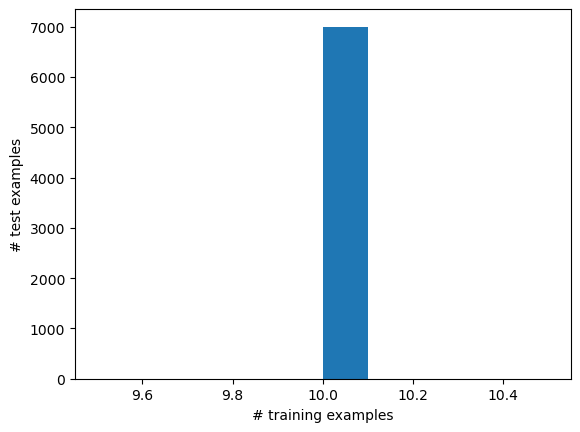

In [23]:
lengths = [len(w) for w in weights]

plt.hist(lengths, 10)
plt.xlabel("# training examples")
plt.ylabel("# test examples")
plt.show()

Let us compare the predictive performance of the original and the constrained predictions.

In [24]:
rf_predicted_labels = np.array([rf.classes_[p.argmax()] for p in rf_predictions])
rfx_predicted_labels = np.array([rfx.classes_[p.argmax()] for p in rfx_predictions_k])

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score

accuracy_orig = accuracy_score(y_test, rf_predicted_labels)
auc_orig = roc_auc_score(y_test, rf_predictions, average='weighted',
                         multi_class='ovr', labels=rf.classes_)

roc_auc_score(y_test == rf.classes_[1], 
                         rf_predictions[:,1])

accuracy_k = accuracy_score(y_test, rfx_predicted_labels)
auc_k = roc_auc_score(y_test, rfx_predictions, average='weighted',
                      multi_class='ovr', labels=rfx.classes_)

df_result = pd.DataFrame([[accuracy_orig, auc_orig],[accuracy_k, auc_k]], 
                  index=["Original", f"k={k}"], 
                  columns=["Accuracy", "AUC"])

display(df_result.round(3))

,Accuracy,AUC
Original,0.969,0.999
k=5,0.973,0.999


Let us take a look at the training examples that are used for some prediction.

Test example:


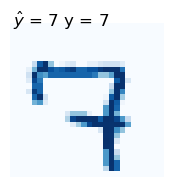

,0,1,2,3,4,5,6,7,8,9
,0.01,0.00,0.10,0.09,0.07,0.01,0.01,0.49,0.01,0.20


,0,1,2,3,4,5,6,7,8,9
,0.00,0.00,0.12,0.22,0.00,0.00,0.00,0.62,0.00,0.05


Training examples:


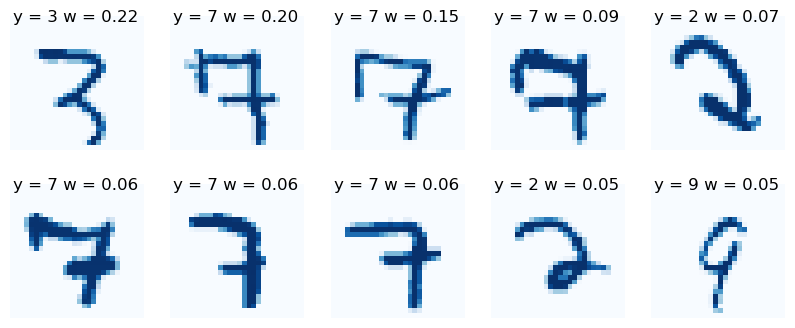

In [26]:
test_index = 0 # Select any test example

print("Test example:")
test_pixels = X_test[test_index].reshape((28, 28))

plt.figure(figsize=(2,2))
plt.imshow(test_pixels, cmap='Blues')
plt.axis('off')
plt.text(0.1, 0.1, r"$\hat{y}$" +f" = {rfx_predicted_labels[test_index]} y = {y_test[test_index]}", 
         fontsize = 12)
plt.show()

df = pd.DataFrame([rf_predictions[test_index]], index = [""], columns=rf.classes_)
display(df.style.format(precision=2).set_caption("Original prediction").set_table_styles(Styles))

df = pd.DataFrame([rfx_predictions_k[test_index]], index = [""], columns=rfx.classes_)
display(df.style.format(precision=2).set_caption("Constrained prediction").set_table_styles(Styles))
                                                                                                 
print("Training examples:")

no_rows = 2
no_cols = 5

fig, axs = plt.subplots(no_rows, no_cols, figsize=(10, 4))

for i, train_ind in enumerate(examples[test_index]):
    pixels = X_train[train_ind].reshape((28, 28))
    row = i // no_cols
    col = i % no_cols
    axs[row, col].imshow(pixels, cmap='Blues')
    axs[row, col].axis('off')
    axs[row, col].text(0.1, 0.5, f"y = {y_train[train_ind]} w = {weights[test_index][i]:.2f}", fontsize = 12)
plt.show()

## Regression forests

### Miami housing

Let us import the Miami housing dataset from [openml.org](www.openml.org).

In [27]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

dataset = fetch_openml(name="miami_housing", parser="auto")

y = dataset.target.values
X = dataset.data.values

Let us split the dataset into a training and a test set.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)

Let us first generate a standard random forest regressor and apply it to the test set.

In [29]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

np.random.seed(42)

rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

Similarly, we may generate and apply an explainable random forest regressor, here without constraining the number of training examples involved in the predictions.

In [30]:
from xrf import XRandomForestRegressor

np.random.seed(42)

rfx = XRandomForestRegressor(n_jobs=-1)
rfx.fit(X_train, y_train)
rfx_predictions = rfx.predict(X_test)

Let us check that we indeed get the same predictions.

In [31]:
assert np.allclose(rf_predictions, rfx_predictions)

We may now limit the number of examples involved in a prediction, e.g., to at most 5 (`k=5`).

In [32]:
k=5

rfx_predictions_k, examples, weights  = rfx.predict(X_test, 
                                                    k=k,
                                                    return_examples=True, 
                                                    return_weights=True)

Let us compare the correctness of the constrained and original predictions.

In [33]:
from sklearn.metrics import mean_squared_error

rmse_orig = np.sqrt(mean_squared_error(y_test, rf_predictions))
corr_orig = np.corrcoef(y_test, rf_predictions)[0,1]

rmse_k = np.sqrt(mean_squared_error(y_test, rfx_predictions_k))
corr_k = np.corrcoef(y_test, rfx_predictions_k)[0,1]

df_result = pd.DataFrame([[rmse_orig, corr_orig],[rmse_k, corr_k]], 
                  index=["Original", f"k={k}"], 
                  columns=["RMSE", "CORR"])

display(df_result.round(3))

,RMSE,CORR
Original,110805.864,0.943
k=5,110476.683,0.940


Let us take a look at the training examples that are used for some prediction.

In [34]:
test_index = 0 # Select any test example
#test_index = np.argwhere(rfx_predicted_labels != y_test)[1,0] # Select a misclassified test example
#test_index = np.argwhere(rfx_predicted_labels != rf_predicted_labels)[2,0] # Select a test example on which there is disagreement

import pandas as pd

print(f"Original prediction: {rf_predictions[test_index]:.1f}")
print(f"Constrained prediction: {rfx_predictions_k[test_index]:.1f}")

df = pd.DataFrame(np.hstack((np.vstack((y_test[test_index], np.nan, X_test[test_index].reshape(-1,1))),
                             np.hstack((y_train[examples[test_index]].reshape(k,1),
                                        weights[test_index].reshape(k,1),
                                        X_train[examples[test_index]])).T)),
                            index = ["Target", "Weight"]+dataset.feature_names, 
                  columns=["Test"]+["#"+str(i+1) for i in range(k)])

df.apply(pd.to_numeric).style.format(precision=2, thousands=" ", na_rep=" ").\
   background_gradient(cmap="Reds", axis=1)

Original prediction: 699005.0
Constrained prediction: 720471.4


,Test,#1,#2,#3,#4,#5
Target,756 600.00,769 400.00,541 000.00,772 200.00,565 000.00,685 000.00
Weight,,0.64,0.12,0.09,0.07,0.07
LATITUDE,25.70,25.70,25.71,25.67,25.69,25.85
LONGITUDE,-80.35,-80.35,-80.34,-80.32,-80.35,-80.38
LND_SQFOOT,12 501.00,18 247.00,14 896.00,15 015.00,10 316.00,5 721.00
TOT_LVG_AREA,3 221.00,3 071.00,2 855.00,3 235.00,3 306.00,3 008.00
SPEC_FEAT_VAL,4 960.00,4 576.00,2 130.00,899.00,672.00,0.00
RAIL_DIST,3 045.30,3 182.10,2 097.60,4 637.60,294.10,7 095.20
OCEAN_DIST,30 885.40,31 046.20,29 471.00,17 311.20,28 968.20,63 878.60
WATER_DIST,16 126.20,16 176.90,13 865.80,11 664.30,18 551.70,11 893.00


### Lipophilicty

In [35]:
import numpy as np
import pandas as pd
import rdkit
from rdkit.Chem import AllChem

url = ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/"
       "Lipophilicity.csv")

df = pd.read_csv(url)

y = df["exp"].values

molecules = [rdkit.Chem.MolFromSmiles(s) for s in df["smiles"]]

fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=1024)

X = np.array([fpgen.GetFingerprint(m) for m in molecules])

print(X.shape)

(4200, 1024)


Let us split the dataset into a training and a test set.

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, molecules_train, molecules_test = \
    train_test_split(X, y, molecules, test_size=0.75)

Let us first generate a standard random forest regressor and apply it to the test set.

In [37]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

np.random.seed(42)

rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

Similarly, we may generate and apply an explainable random forest regressor, here without constraining the number of training examples involved in the predictions.

In [38]:
from xrf import XRandomForestRegressor

np.random.seed(42)

rfx = XRandomForestRegressor(n_estimators=500, n_jobs=-1)
rfx.fit(X_train, y_train)
rfx_predictions = rfx.predict(X_test)

Let us check that we indeed get the same predictions.

In [39]:
assert np.allclose(rf_predictions, rfx_predictions)

We may now limit the number of examples involved in a prediction, e.g., to at most 10 (`k=10`).

In [40]:
k=10

rfx_predictions_k, examples, weights  = rfx.predict(X_test, 
                                                    k=k,
                                                    return_examples=True, 
                                                    return_weights=True)

Let us compare the correctness of the constrained and original predictions.

In [41]:
from sklearn.metrics import mean_squared_error

rmse_orig = np.sqrt(mean_squared_error(y_test, rf_predictions))
corr_orig = np.corrcoef(y_test, rf_predictions)[0,1]

rmse_k = np.sqrt(mean_squared_error(y_test, rfx_predictions_k))
corr_k = np.corrcoef(y_test, rfx_predictions_k)[0,1]

df_result = pd.DataFrame([[rmse_orig, corr_orig],[rmse_k, corr_k]], 
                  index=["Original", f"k={k}"], 
                  columns=["RMSE", "CORR"])

display(df_result.round(3))

,RMSE,CORR
Original,0.951,0.621
k=10,0.978,0.599


Let us take a look at some test example and the training examples that are used for the prediction.

In [42]:
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdDepictor

IPythonConsole.ipython_useSVG=False
IPythonConsole.drawOptions.minFontSize=20

rdDepictor.SetPreferCoordGen(True)

def show_difference(mol1, w, y, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
    return Draw.MolsToGridImage([mol1],
                                highlightAtomLists=[target_atm1], 
                                useSVG=True)

Test molecule:


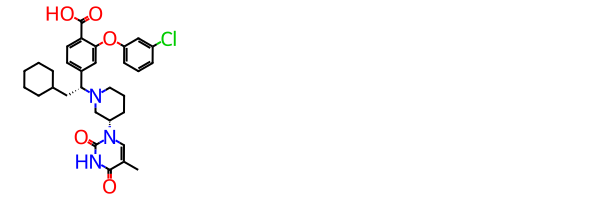

True target: 1.83
Original prediction: 0.19
Constrained prediction: 0.06

Training example 1 [-0.25, weight: 0.43]


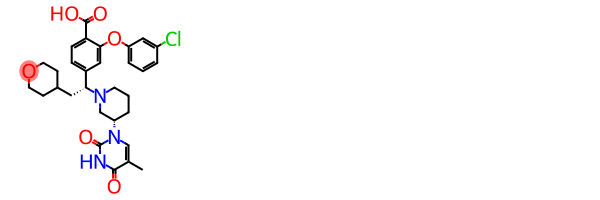

Training example 2 [0.22, weight: 0.19]


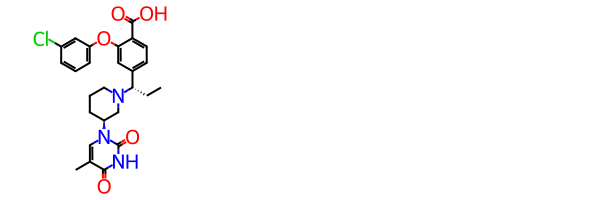

Training example 3 [0.6, weight: 0.16]


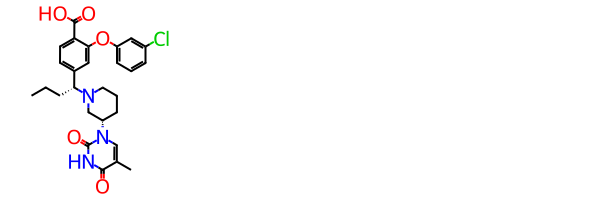

Training example 4 [-0.26, weight: 0.14]


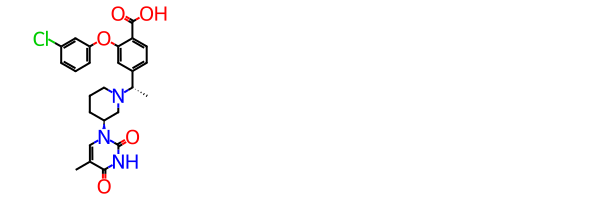

Training example 5 [1.09, weight: 0.05]


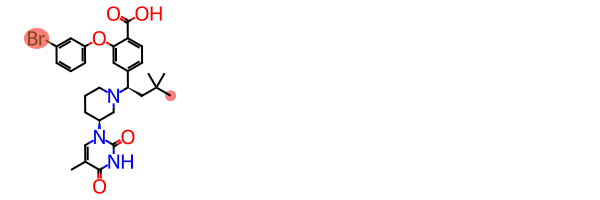

Training example 6 [-0.51, weight: 0.01]


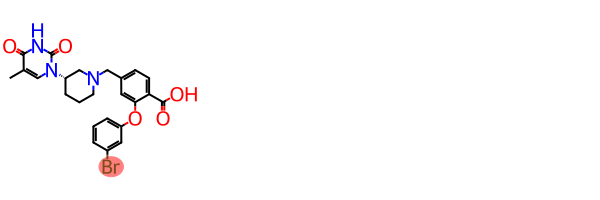

Training example 7 [-0.34, weight: 0.01]


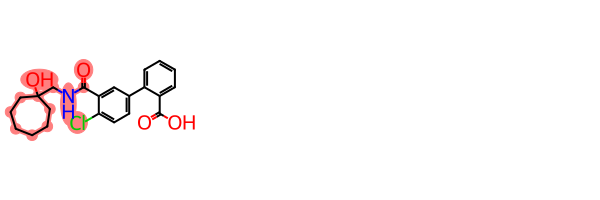

Training example 8 [2.43, weight: 0.00]


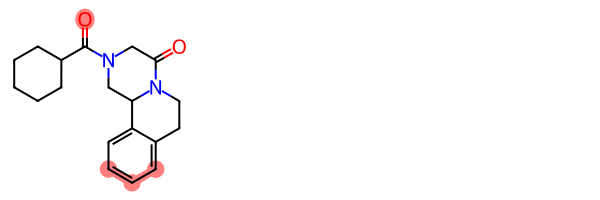

Training example 9 [1.03, weight: 0.00]


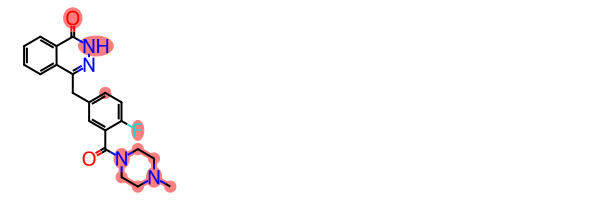

Training example 10 [1.1, weight: 0.00]


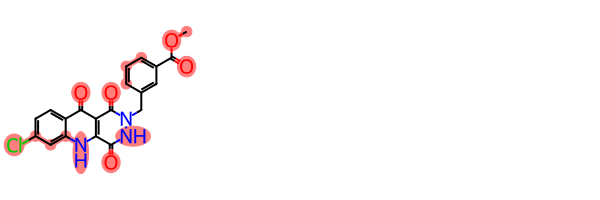

In [43]:
test_index = 5 # Select any test example

print("Test molecule:")
test_mol = molecules_test[test_index]
test_mol_fig = Draw.MolsToGridImage([test_mol], useSVG=True)
display(test_mol_fig)
print(f"True target: {y_test[test_index]:.2f}")
print(f"Original prediction: {rf_predictions[test_index]:.2f}")
print(f"Constrained prediction: {rfx_predictions_k[test_index]:.2f}\n")

for i, training_index in enumerate(examples[test_index]):
    print(f"Training example {i+1} "
          f"[{y_train[training_index]}, "   
          f"weight: {weights[test_index][i]:.2f}]")    
    training_mol = molecules_train[training_index]
    train_mol_fig = show_difference(training_mol, weights[test_index][i], 
                                    y_train[training_index], test_mol)
    display(train_mol_fig)